## Testing Surrogated-Sources Approach

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

from scipy.integrate import solve_ivp

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerRestTrain      = 2000
tStratch           = 1.
NtTrain            = NPerRestTrain*2
SOLVER             = 'BDF'

NNeurons           = [32,64,128,64,32]
Activations        = [activations.relu, activations.relu, activations.relu, activations.relu, activations.relu]
NEpoch             = 2500
NBatch             = 128
LearningRate       = 1.e-4
RegCoeff           = 1.e-4
OptimizerName      = tf.optimizers.Adam

In [3]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    
# NRests             = 10
# for iRest in range(NRests):

#     FileName     = OutputDir+'/pc_data_3/PC.csv.'+str(iRest+1) 
#     Data         = pd.read_csv(FileName, header=0)
#     tVec         = Data['t'].to_numpy()
#     yMat         = Data[Vars].to_numpy()
    
#     FileName     = OutputDir+'/pc_data_3/PCSource.csv.'+str(iRest+1) 
#     DataS        = pd.read_csv(FileName, header=0)
#     ySource      = DataS[SVars].to_numpy()
    
FileName     = OutputDir + '/orig_data/yCleaned.csv'
yMatOrig     = pd.read_csv(FileName, header=0)
VarNames     = list(yMatOrig.columns)
yMat         = yMatOrig.to_numpy()

FileName     = OutputDir + '/orig_data/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
FileName     = OutputDir+'/orig_data/t.csv'
Data         = pd.read_csv(FileName, header=None)
tVec         = Data.to_numpy()[:,0]

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data         = pd.read_csv(FileName, header=0)
yMat_pca     = Data[Vars].to_numpy()

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS        = pd.read_csv(FileName, header=0)
ySource_pca  = DataS[SVars].to_numpy()

In [4]:
# fig  = plt.figure(figsize=(16,12))
# plt.plot(tVec, yMat_pca[:,2], '-k',  linewidth=2)
# plt.xscale('log')

Text(0.5, 0, '$dPC_3/dt$')

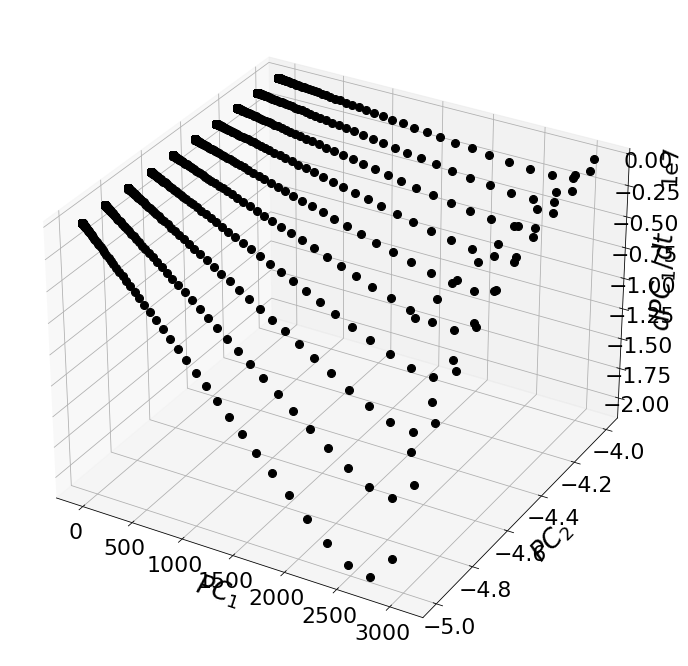

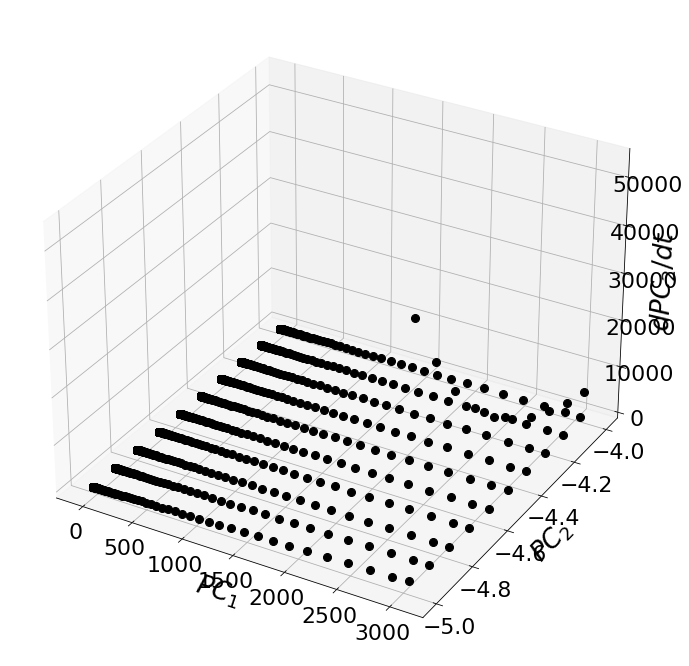

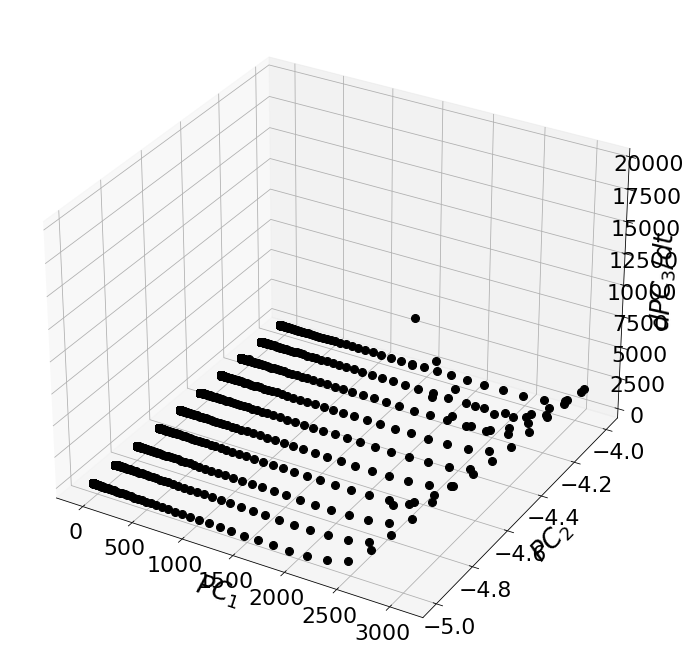

In [5]:
# Plotting Sources vs States

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,0], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_1/dt$')

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,1], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_2/dt$')

# fig  = plt.figure(figsize=(16,12))
# ax   = plt.axes(projection='3d')
# ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,2], 'ok',  linewidth=2)
# ax.set_xlabel(r'$PC_1$')
# ax.set_ylabel(r'$PC_2$')
# ax.set_zlabel(r'$dPC_3/dt$')




fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

In [6]:
### Normalizing Data

yMat_pca  = np.concatenate((yMat_pca, RestVecTot), axis=1)
xMax      = yMat_pca.max(0)
xMin      = yMat_pca.min(0)
xRange    = (xMax-xMin)
if (xRange[-1] == 0):
    xRange[-1] = 1.0
yMatt_pca = (yMat_pca-xMin)/xRange

yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
ySourcee_pca = (ySource_pca-yMin)/yRange

Nx = yMatt_pca.shape[1]
Nd = yMatt_pca.shape[0]
Ny = ySourcee_pca.shape[1]

Text(0.5, 0, '$dPC_3/dt$')

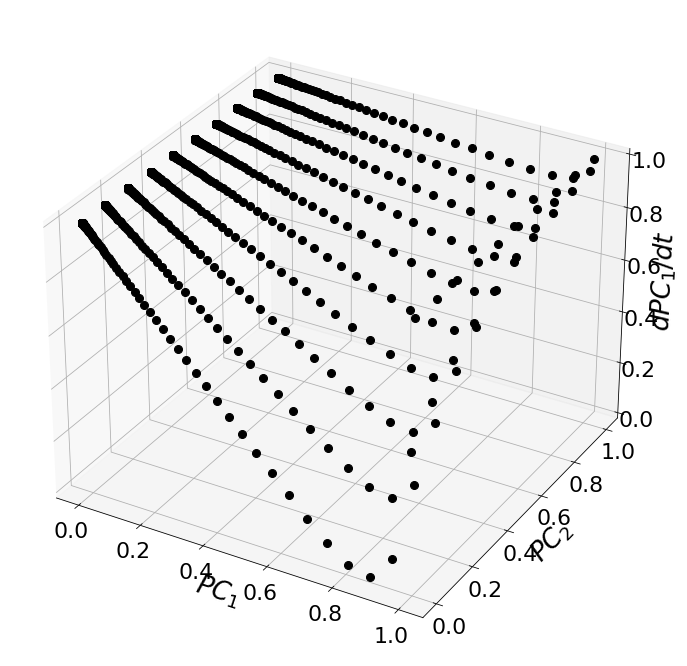

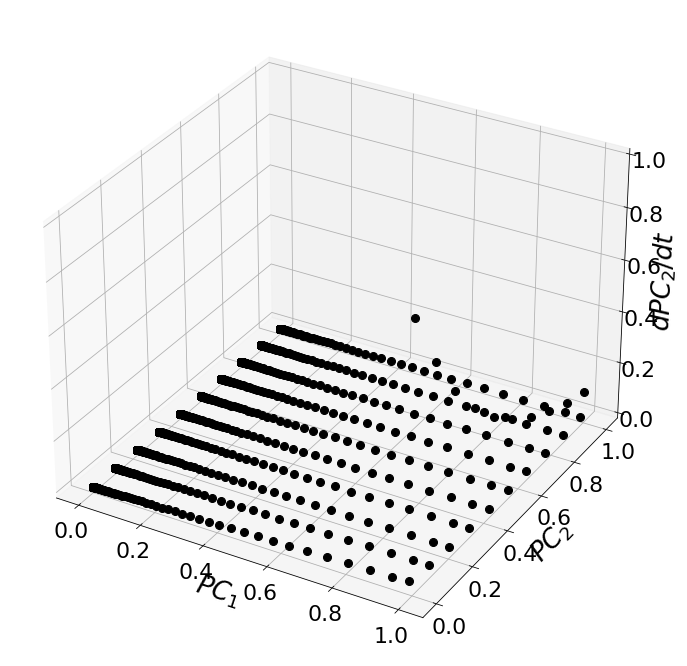

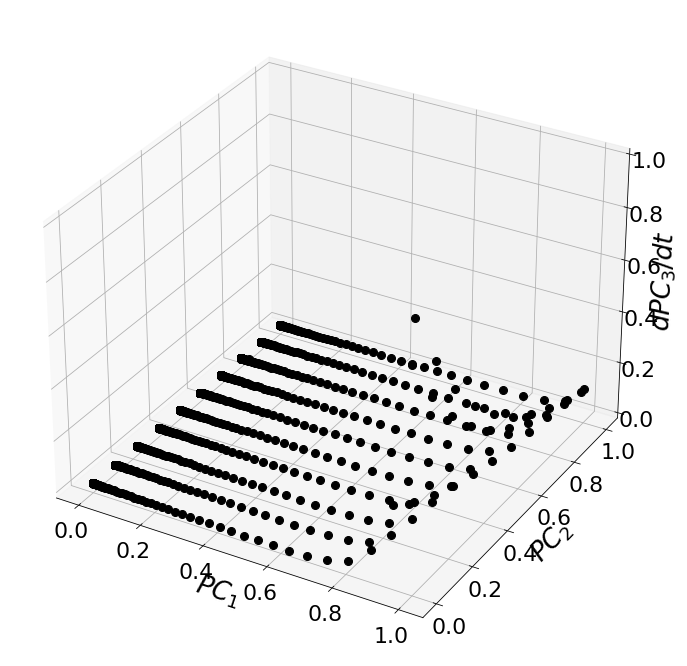

In [7]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

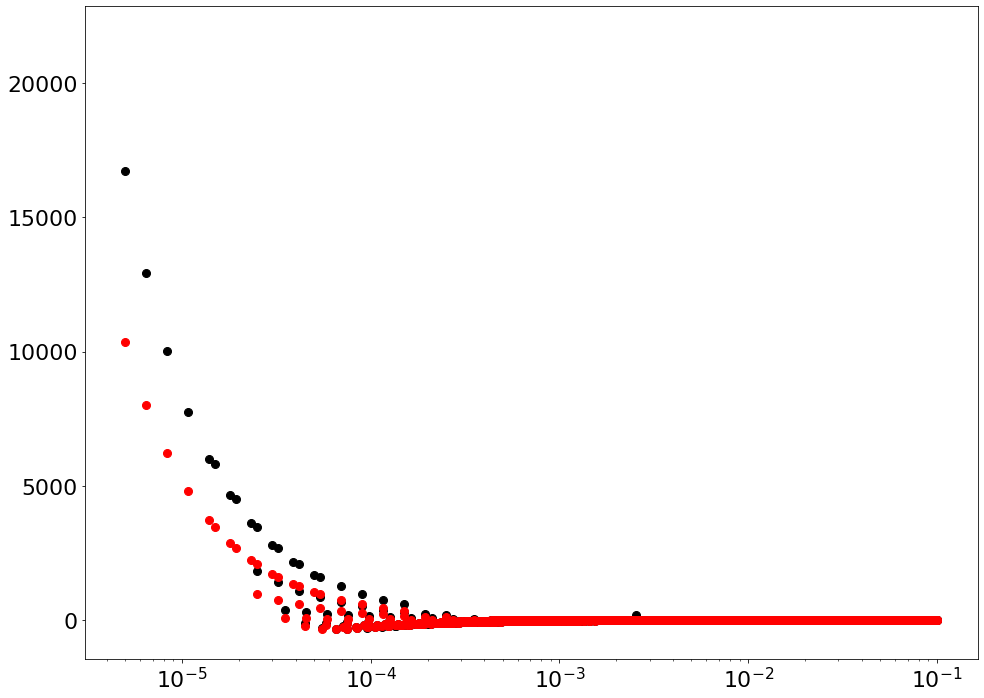

In [8]:
### Checking Data

from numpy import diff

iPC = 2

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[0:-1], dydt, 'ro')
plt.xscale('log')

In [9]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt_pca, ySourcee_pca, test_size=0.2, random_state=3)

In [10]:
### Creating Surrogate

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 21,027
Trainable params: 21,027
Non-trainable params: 0
____________________________________________________

In [ ]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training  = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

Epoch 1/2500
63/63 [==============================] - 4s 15ms/step - loss: 0.2352 - val_loss: 0.1358
Epoch 2/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0696 - val_loss: 0.0297
Epoch 3/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0263 - val_loss: 0.0253
Epoch 4/2500
63/63 [==============================] - 0s 6ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 5/2500
63/63 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.0221
Epoch 6/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 7/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0200 - val_loss: 0.0197
Epoch 8/2500
63/63 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 9/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 10/2500
63/63 [==============================] - 0s 5ms/step - loss: 0.0173 - val_loss: 0.017

63/63 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 83/2500
63/63 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 84/2500
63/63 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 85/2500
63/63 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 86/2500
63/63 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 87/2500
63/63 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 88/2500
63/63 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 89/2500
63/63 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 90/2500
63/63 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 91/2500
63/63 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0036
Epoc

63/63 [==============================] - 0s 7ms/step - loss: 9.8955e-04 - val_loss: 0.0013
Epoch 163/2500
63/63 [==============================] - 1s 9ms/step - loss: 9.7990e-04 - val_loss: 0.0013
Epoch 164/2500
63/63 [==============================] - 1s 9ms/step - loss: 9.7045e-04 - val_loss: 0.0012
Epoch 165/2500
63/63 [==============================] - 1s 8ms/step - loss: 9.6035e-04 - val_loss: 0.0012
Epoch 166/2500
63/63 [==============================] - 0s 7ms/step - loss: 9.5095e-04 - val_loss: 0.0012
Epoch 167/2500
63/63 [==============================] - 0s 8ms/step - loss: 9.4244e-04 - val_loss: 0.0012
Epoch 168/2500
63/63 [==============================] - 1s 9ms/step - loss: 9.3364e-04 - val_loss: 0.0012
Epoch 169/2500
63/63 [==============================] - 1s 9ms/step - loss: 9.2542e-04 - val_loss: 0.0012
Epoch 170/2500
63/63 [==============================] - 1s 8ms/step - loss: 9.1792e-04 - val_loss: 0.0012
Epoch 171/2500
63/63 [==============================] - 1s 8m

63/63 [==============================] - 0s 5ms/step - loss: 6.9186e-04 - val_loss: 9.6648e-04
Epoch 239/2500
63/63 [==============================] - 0s 5ms/step - loss: 6.9157e-04 - val_loss: 9.6343e-04
Epoch 240/2500
63/63 [==============================] - 0s 5ms/step - loss: 6.9006e-04 - val_loss: 9.6371e-04
Epoch 241/2500
63/63 [==============================] - 0s 6ms/step - loss: 6.8845e-04 - val_loss: 9.6217e-04
Epoch 242/2500
63/63 [==============================] - 0s 5ms/step - loss: 6.8669e-04 - val_loss: 9.6056e-04
Epoch 243/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.8621e-04 - val_loss: 9.5919e-04
Epoch 244/2500
63/63 [==============================] - 0s 6ms/step - loss: 6.8457e-04 - val_loss: 9.5821e-04
Epoch 245/2500
63/63 [==============================] - 1s 8ms/step - loss: 6.8321e-04 - val_loss: 9.5628e-04
Epoch 246/2500
63/63 [==============================] - 0s 8ms/step - loss: 6.8133e-04 - val_loss: 9.5461e-04
Epoch 247/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 6.2904e-04 - val_loss: 9.0356e-04
Epoch 313/2500
63/63 [==============================] - 0s 5ms/step - loss: 6.2809e-04 - val_loss: 9.0191e-04
Epoch 314/2500
63/63 [==============================] - 0s 5ms/step - loss: 6.2731e-04 - val_loss: 9.0235e-04
Epoch 315/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2613e-04 - val_loss: 9.0094e-04
Epoch 316/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2551e-04 - val_loss: 9.0084e-04
Epoch 317/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2457e-04 - val_loss: 9.0101e-04
Epoch 318/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2441e-04 - val_loss: 9.0166e-04
Epoch 319/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2406e-04 - val_loss: 8.9850e-04
Epoch 320/2500
63/63 [==============================] - 0s 4ms/step - loss: 6.2348e-04 - val_loss: 8.9918e-04
Epoch 321/2500
63/63 [===

63/63 [==============================] - 0s 4ms/step - loss: 5.9447e-04 - val_loss: 8.7250e-04
Epoch 387/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9360e-04 - val_loss: 8.6984e-04
Epoch 388/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9310e-04 - val_loss: 8.6955e-04
Epoch 389/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9316e-04 - val_loss: 8.6925e-04
Epoch 390/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9279e-04 - val_loss: 8.7038e-04
Epoch 391/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9246e-04 - val_loss: 8.6954e-04
Epoch 392/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9230e-04 - val_loss: 8.6900e-04
Epoch 393/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9181e-04 - val_loss: 8.6887e-04
Epoch 394/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.9079e-04 - val_loss: 8.6781e-04
Epoch 395/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 5.7180e-04 - val_loss: 8.4947e-04
Epoch 461/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7173e-04 - val_loss: 8.5249e-04
Epoch 462/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7260e-04 - val_loss: 8.5089e-04
Epoch 463/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7206e-04 - val_loss: 8.5090e-04
Epoch 464/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7146e-04 - val_loss: 8.4928e-04
Epoch 465/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7118e-04 - val_loss: 8.4870e-04
Epoch 466/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7115e-04 - val_loss: 8.4973e-04
Epoch 467/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.7075e-04 - val_loss: 8.5034e-04
Epoch 468/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.7015e-04 - val_loss: 8.4990e-04
Epoch 469/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 5.5456e-04 - val_loss: 8.3486e-04
Epoch 535/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.5478e-04 - val_loss: 8.3624e-04
Epoch 536/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.5619e-04 - val_loss: 8.3702e-04
Epoch 537/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.5397e-04 - val_loss: 8.3600e-04
Epoch 538/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.5533e-04 - val_loss: 8.3571e-04
Epoch 539/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.5409e-04 - val_loss: 8.3550e-04
Epoch 540/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.5433e-04 - val_loss: 8.3435e-04
Epoch 541/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.5302e-04 - val_loss: 8.3374e-04
Epoch 542/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.5396e-04 - val_loss: 8.3508e-04
Epoch 543/2500
63/63 [===

63/63 [==============================] - 0s 4ms/step - loss: 5.4106e-04 - val_loss: 8.2306e-04
Epoch 609/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.4052e-04 - val_loss: 8.2291e-04
Epoch 610/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.4048e-04 - val_loss: 8.2341e-04
Epoch 611/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.4041e-04 - val_loss: 8.2411e-04
Epoch 612/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.4081e-04 - val_loss: 8.2492e-04
Epoch 613/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.3976e-04 - val_loss: 8.2213e-04
Epoch 614/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.3975e-04 - val_loss: 8.2228e-04
Epoch 615/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.4037e-04 - val_loss: 8.2130e-04
Epoch 616/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.3984e-04 - val_loss: 8.2185e-04
Epoch 617/2500
63/63 [===

63/63 [==============================] - 0s 4ms/step - loss: 5.2979e-04 - val_loss: 8.1339e-04
Epoch 683/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2927e-04 - val_loss: 8.1304e-04
Epoch 684/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2888e-04 - val_loss: 8.1343e-04
Epoch 685/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2956e-04 - val_loss: 8.1389e-04
Epoch 686/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2902e-04 - val_loss: 8.1389e-04
Epoch 687/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2908e-04 - val_loss: 8.1265e-04
Epoch 688/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2829e-04 - val_loss: 8.1184e-04
Epoch 689/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.2830e-04 - val_loss: 8.1228e-04
Epoch 690/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.2767e-04 - val_loss: 8.1336e-04
Epoch 691/2500
63/63 [===

63/63 [==============================] - 0s 4ms/step - loss: 5.1896e-04 - val_loss: 8.0428e-04
Epoch 757/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1909e-04 - val_loss: 8.0459e-04
Epoch 758/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1933e-04 - val_loss: 8.0495e-04
Epoch 759/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1872e-04 - val_loss: 8.0485e-04
Epoch 760/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1853e-04 - val_loss: 8.0463e-04
Epoch 761/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1905e-04 - val_loss: 8.0690e-04
Epoch 762/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1861e-04 - val_loss: 8.0530e-04
Epoch 763/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1850e-04 - val_loss: 8.0314e-04
Epoch 764/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1796e-04 - val_loss: 8.0515e-04
Epoch 765/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 5.1028e-04 - val_loss: 7.9800e-04
Epoch 831/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1030e-04 - val_loss: 7.9651e-04
Epoch 832/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.0978e-04 - val_loss: 7.9617e-04
Epoch 833/2500
63/63 [==============================] - 0s 7ms/step - loss: 5.1040e-04 - val_loss: 7.9688e-04
Epoch 834/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.1056e-04 - val_loss: 7.9661e-04
Epoch 835/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.0945e-04 - val_loss: 7.9762e-04
Epoch 836/2500
63/63 [==============================] - 0s 4ms/step - loss: 5.0959e-04 - val_loss: 7.9686e-04
Epoch 837/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1070e-04 - val_loss: 7.9770e-04
Epoch 838/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.1019e-04 - val_loss: 7.9726e-04
Epoch 839/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 5.0245e-04 - val_loss: 7.9057e-04
Epoch 905/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.0228e-04 - val_loss: 7.9023e-04
Epoch 906/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.0311e-04 - val_loss: 7.9036e-04
Epoch 907/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.0352e-04 - val_loss: 7.8931e-04
Epoch 908/2500
63/63 [==============================] - 0s 5ms/step - loss: 5.0176e-04 - val_loss: 7.8985e-04
Epoch 909/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.0165e-04 - val_loss: 7.8848e-04
Epoch 910/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.0303e-04 - val_loss: 7.8910e-04
Epoch 911/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.0236e-04 - val_loss: 7.8891e-04
Epoch 912/2500
63/63 [==============================] - 0s 6ms/step - loss: 5.0198e-04 - val_loss: 7.9325e-04
Epoch 913/2500
63/63 [===

63/63 [==============================] - 0s 5ms/step - loss: 4.9515e-04 - val_loss: 7.8386e-04
Epoch 979/2500
63/63 [==============================] - 0s 5ms/step - loss: 4.9503e-04 - val_loss: 7.8401e-04
Epoch 980/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.9515e-04 - val_loss: 7.8587e-04
Epoch 981/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.9475e-04 - val_loss: 7.8497e-04
Epoch 982/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.9523e-04 - val_loss: 7.8764e-04
Epoch 983/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.9571e-04 - val_loss: 7.8576e-04
Epoch 984/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.9513e-04 - val_loss: 7.8516e-04
Epoch 985/2500
63/63 [==============================] - 0s 5ms/step - loss: 4.9469e-04 - val_loss: 7.8401e-04
Epoch 986/2500
63/63 [==============================] - 0s 5ms/step - loss: 4.9524e-04 - val_loss: 7.8913e-04
Epoch 987/2500
63/63 [===

63/63 [==============================] - 0s 4ms/step - loss: 4.8891e-04 - val_loss: 7.7901e-04
Epoch 1053/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8871e-04 - val_loss: 7.7731e-04
Epoch 1054/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8879e-04 - val_loss: 7.8236e-04
Epoch 1055/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8901e-04 - val_loss: 7.7684e-04
Epoch 1056/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8832e-04 - val_loss: 7.8079e-04
Epoch 1057/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8937e-04 - val_loss: 7.8067e-04
Epoch 1058/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8784e-04 - val_loss: 7.8031e-04
Epoch 1059/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8760e-04 - val_loss: 7.7657e-04
Epoch 1060/2500
63/63 [==============================] - 0s 4ms/step - loss: 4.8832e-04 - val_loss: 7.7742e-04
Epoch 1061/2500
6

In [ ]:
### Checking Predictive Accuracy

ySource_pca_ = NNModel.predict(yMatt_pca)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee_pca[:,iy])
    xMax_ = np.amax(ySourcee_pca[:,iy])
    plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

In [ ]:
ySourcee_pca_ = NNModel.predict(yMatt_pca)


fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,0], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_1/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,1], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_2/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,2], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_3/dt$')
ax.legend()


In [ ]:
fig  = plt.figure(figsize=(16,12))
plt.plot( tVec, yMat_pca[:,2], '-k',  linewidth=2)
plt.xscale('log')

In [ ]:
# NNModel = []

# for iy in range(1,2):


#     ### Creating Surrogate

#     LengthScale               = 5.e-2
#     Tau                       = 1.
#     RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

#     NNModel.append(tf.keras.models.Sequential())

#     NNModel[-1].add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     for iHL in range(1, len(NNeurons)):
#         NNModel[-1].add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     NNModel[-1].add(Dense(Ny, activation='linear'))
#     NNModel[-1].summary()



#     ### Training Surrogate

#     Optimizer = OptimizerName(learning_rate=LearningRate)
#     NNModel[-1].compile(optimizer=Optimizer, loss='mse')
#     Training  = NNModel[-1].fit(XTrain, yTrain[:,iy], batch_size=NBatch, epochs=1000, validation_data=(XTest, yTest[:,iy]), verbose=1);

#     LossTrainHystory = Training.history['loss']
#     LossValidHystory = Training.history['val_loss']



#     # Plotting Training and Validation Loss

#     fig = plt.figure(figsize=(12, 8))
#     plt.plot(LossTrainHystory, 'r', label='Training')
#     plt.plot(LossValidHystory, 'g', label='Validation')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.yscale('log')
#     plt.legend()
# #     FigPath = FigDir+'/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
# #     fig.savefig(FigPath, dpi=900)
    
    
    
#     ### Checking Predictive Accuracy

#     ySource_pca_ = NNModel[-1].predict(yMatt_pca)

#     fig  = plt.figure(figsize=(12,12))
#     xMin_ = np.amin(ySourcee_pca[:,iy])
#     xMax_ = np.amax(ySourcee_pca[:,iy])
#     plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
#     plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
#     plt.xlabel('Data')
#     plt.ylabel('Prediction')

In [ ]:
# ySource_pca_ = NNModel[-1].predict(yMatt_pca)

# fig  = plt.figure(figsize=(12,12))
# xMin_ = np.amin(ySourcee_pca[:,iy])
# xMax_ = np.amax(ySourcee_pca[:,iy])
# plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
# plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
# plt.xlabel('Data')
# plt.ylabel('Prediction')

In [ ]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    print(t)
    #yy   = (y - xMin)/xRange
    yy   = (np.append(y, RestVal) - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

In [ ]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    #tVec         = Data.to_numpy()[:,0]
    ySource_pca  = Data[SVars].to_numpy()
    ySourcee_pca = (ySource_pca-yMin)/yRange

    
    RestVal      = RestValVecTest[iTest]
    print('RestVal = ', RestVal)
    
    yMatt_pca     = (np.concatenate( (yMat_pca, RestVal*np.ones((yMat_pca.shape[0],1))), axis=1) - xMin)/xRange
    ySourcee_pca_ = NNModel.predict(yMatt_pca)
    ySource_pca_  = yRange*ySourcee_pca_ + yMin
     

        
    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,0],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,0], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_1/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,1],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,1], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_2/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca[:,2],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,3], ySourcee_pca_[:,2], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_3/dt$')

In [ ]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/RestVecTot.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    RestVal      = RestValVecTest[iTest]
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    output       = solve_ivp( fOrig_NN, tVec[[0,-1]], y0_pca, method='RK45', t_eval=tVec, atol=1.e-8 )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

In [ ]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()
#plt.ylim([-2000.0, 2500.])

In [ ]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [ ]:
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

In [ ]:
VarOI = 'CO'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1], '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()

In [ ]:
ModelFile = OutputDir + '/NN_Sources/'

NNModel.save(ModelFile)

In [ ]:
### Write Data

FileName       = OutputDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVec     = np.log10(Data.to_numpy())

for iTrain in range(10):

    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    yMat_pca     = Data[Vars].to_numpy()
    
    RestVal      = RestValVec[iTrain]
    RestVec      = np.ones((yMat_pca.shape[0],1)) * RestVal
    yMat_pca     = np.concatenate( (yMat_pca, RestVec), axis=1 )
    
    FileName     = '/Users/sventuri/Desktop/Data/PC_Augmented.csv.'+str(iTrain+1)
    Header       = 'PC1,PC2,PC3,log10(ResTime)'
    np.savetxt(FileName, yMat_pca, delimiter=',', header=Header, comments='')
    
    
    
    
    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    ySources_pca = Data[SVars].to_numpy()
    
    FileName     = '/Users/sventuri/Desktop/Data/PCSource.csv.'+str(iTrain+1)
    Header       = 'SPC1,SPC2,SPC3'
    np.savetxt(FileName, ySources_pca, delimiter=',', header=Header, comments='')